In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [2]:
!env | grep PYTHONPATH

In [3]:
import numpy as np
import matplotlib.pylab as plt
import detectron2
import cv2
import os
import pathlib
import json
import random
from PIL import Image, ImageDraw2
import pandas as pd
import torchvision
from torchvision import transforms
import torch
import shutil
import glob

In [18]:
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_train_loader, build_detection_test_loader

### Steps

* dataset generation with one logo
    *  logo -> transform -> overlay on background. bbox known (img dimensions)
    
    * logo with bbox -> transform img and bbox (imgaug)

* exporting to onnx and make it work with existing code

## Dataset Generation

* Offline

    * Generate N arbitrary colored backgrounds (DONE)

    * Transform transparent logo (DONE)
    
    * Overlay transformed and transparent logo onto background (DONE)
    
    * Save image and bounding box (DONE)

In [ ]:
def generate_background_image(color_center, color_edge, size=(512,512)):
    #distance calculation
    row_idx = np.repeat(np.arange(0, size[0]), size[1], axis=0).reshape(size)
    col_idx = np.repeat(np.arange(0, size[1]), size[0], axis=0).reshape((size[1], size[0])).T    
    
    center = (size[0]/2, size[1]/2)
    dist = np.zeros(size)
    dist = np.sqrt((row_idx - center[0])**2 + (col_idx - center[1])**2)
    max_dist = np.max(dist)
    dist /= max_dist    
    
    #colors
    r = color_edge[0] * dist + color_center[0] * (1-dist)
    g = color_edge[1] * dist + color_center[1] * (1-dist)
    b = color_edge[2] * dist + color_center[2] * (1-dist)    
    
    #check artifacts with Image.fromarray()
    img = Image.new('RGBA', size)
    for y in range(size[1]):
        for x in range(size[0]):
            img.putpixel((x,y), (int(r[x,y]), int(g[x,y]), int(b[x,y])))
    
    return img

def retrieve_background_image(LOC):
    raise NotImplementedError

def make_logo_transparent(logo, threshold_color=[200,200,200]):
    logo = logo.convert('RGBA')
    data = logo.getdata()
    
    data_alpha = []
    for pixel in data:
        #if pixel[0]>200 and pixel[1]>200 and pixel[2]>200:
        if pixel[0]>threshold_color[0] and pixel[1] > threshold_color[1] and pixel[2] > threshold_color[2]:
            data_alpha.append((pixel[0], pixel[1], pixel[2], 0))
            #data_alpha.append((0,255,0,0))
        else:
            data_alpha.append((pixel[0], pixel[1], pixel[2], pixel[3]))
        
    logo.putdata(data_alpha)
    
    return logo

In [ ]:
logo = Image.open('RHLOGO.jpg')
logo = make_logo_transparent(logo)
logo

In [ ]:
logo = Image.open('ANACONDALOGO.jpg')
logo = make_logo_transparent(logo)
logo = logo.resize((128,128))
logo

In [ ]:
logo = Image.open('CLOUDERALOGO.jpg')
logo = make_logo_transparent(logo)
logo = logo.resize((128,128))
logo

In [ ]:
img = generate_background_image((0,80,0), (0,0,80), size=(256,256))
img

In [ ]:
#test overlay
img_new = img.copy()
img_new.paste(logo, (50,50), logo)
img_new

In [ ]:
img_new = img.copy()
logo_tfs = torchvision.transforms.Grayscale()(logo)

img_new.paste(logo_tfs, (50,50), logo)
img_new

In [ ]:
img_new = img.copy()
logo_tfs = torchvision.transforms.RandomAffine(45, translate=(0.1,0.1), scale=(1,1), shear=10)(logo)

img_new.paste(logo_tfs, (50,50), logo_tfs)
img_new


In [ ]:
def generate_augmented_image(size=(512,512),
                             logo_file='CLOUDERALOGO.jpg',
                             N_tfms_to_apply=2,
                             low_frac=0.30,
                             high_frac=0.90):
        
    logo = Image.open(logo_file) #inefficient to open N times but okay for now

    #logo
    #step 1: get resize parameters
    #low_frac = 0.30
    #high_frac = 0.90
    frac0 = (np.random.random()*(high_frac-low_frac) + low_frac)
    frac1 = (np.random.random()*(high_frac-low_frac) + low_frac)
    logo_size = (int(frac0*size[0]), int(frac1*size[1]))

    #logo_size = (128,128) #introduce some randomness

    #step 2: get mask and apply resizing
    logo = make_logo_transparent(logo)
    logo = logo.resize(logo_size)

    #step 3: apply transformations
    tfms_list = [                
                    transforms.RandomRotation(45, expand=False, fill=255),
                    #transforms.RandomAffine(0, translate=(0.3,0.3)), #for truncations
                    transforms.RandomAffine(0, shear=(30,30))
                ]

    N_tfms = len(tfms_list)

    logo_tfms = logo.copy()
    for i in range(N_tfms_to_apply): #apply N transformations
        logo_tfms = tfms_list[np.random.randint(N_tfms)](logo_tfms)
        #logo_tfms = make_logo_transparent(logo_tfms)

    logo_tfms = make_logo_transparent(logo_tfms)

    #step 4: background image 
    colors = [(255,0,0), (0,255,0), (0,0,255), (128,0,0), (0,128,0), (0,0,128), 
              (0,0,0), (255,255,255), (128,128,128),        
              (255,255,0), (255,0,255), (0,255,255), (128,128,0), (128,0,128), (0,128,128)]
    N_colors = len(colors)

    colors_picked = np.array(colors)[np.random.randint(0, N_colors, size=2)]

    bkg = generate_background_image(colors_picked[0], colors_picked[1], size=size)

    #step 5: superimpose at random locations (actual translations)
    location_x = [0, bkg.size[0]-logo.size[0]]
    location_y = [0, bkg.size[1]-logo.size[1]]

    loc = (np.random.randint(*location_x), np.random.randint(*location_y))

    bkg.paste(logo_tfms, loc, logo_tfms)
    
    return bkg, (*size, *loc, loc[0] + logo_size[0], loc[1] + logo_size[1])

In [ ]:
def visualize_bbox(img, bbox):
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    
    draw.rectangle([(bbox[2],bbox[3]), (bbox[4],bbox[5])], outline=128)
    
    return img_copy

In [ ]:
def generate_random_string(N=6):
    return ''.join([chr(i) for i in np.random.randint(97,122,size=N)])

def generate_augmented_dataset(N_images,
                               size=(512,512),
                               low_frac=0.30,
                               high_frac=0.90,
                               logo_file='CLOUDERALOGO.jpg',
                               N_tfms_to_apply=2,
                               seed=None,
                               save_loc=None,
                               logo_name=None):
    
    if seed is not None: #should really figure out all torch seeds
        np.random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)    
    else:
        torch.backends.cudnn.deterministic = False
    
    img_list, bbox_list = [], []
    for i in range(N_images):
        img, bbox = generate_augmented_image(size, 
                                             logo_file, 
                                             N_tfms_to_apply,
                                             low_frac=low_frac,
                                             high_frac=high_frac)
        img_list.append(img)
        bbox_list.append(bbox)
        
    if save_loc is not None:
        if not os.path.exists(save_loc):
            pathlib.Path(save_loc).mkdir(parents=True, exist_ok=True)
        if logo_name is None:
            raise ValueError("Please enter logo_name if saving images")
                
        csv_fields = {'filename': [],
                      'width': [],
                      'height': [],
                      'class': [],
                      'xmin': [],
                      'ymin': [],
                      'xmax': [],
                      'ymax': []}
                
        for img, bbox in zip(img_list, bbox_list):
            img_name = f'{logo_name}_{generate_random_string()}.png'
            img.save(os.path.join(save_loc, img_name))
            
            csv_fields['filename'].append(os.path.join(save_loc, img_name))
            csv_fields['width'].append(bbox[0])
            csv_fields['height'].append(bbox[1])
            csv_fields['class'].append(logo_name)
            csv_fields['xmin'].append(bbox[2])
            csv_fields['ymin'].append(bbox[3])
            csv_fields['xmax'].append(bbox[4])
            csv_fields['ymax'].append(bbox[5])
            
        pd.DataFrame(csv_fields).to_csv(os.path.join(save_loc, f'{logo_name}.csv'), index=False)
    else:
        csv_fields = None
        
    return img_list, bbox_list, csv_fields

In [ ]:
img_list, bbox_list, csv_fields = generate_augmented_dataset(128, 
                                                             low_frac=0.20,
                                                             high_frac=0.40,
                                                             logo_file='RHLOGO.jpg',
                                                             save_loc='rhlogo/train',
                                                             logo_name='rhlogo')
img_list, bbox_list, csv_fields = generate_augmented_dataset(128, 
                                                             low_frac=0.20,
                                                             high_frac=0.40,
                                                             logo_file='RHLOGO.jpg',
                                                             save_loc='rhlogo/test',
                                                             logo_name='rhlogo')

In [ ]:
#convert csv to json
!python convert_csv_to_detectron.py rhlogo/train/rhlogo.csv rhlogo/train/data.json
!python convert_csv_to_detectron.py rhlogo/test/rhlogo.csv rhlogo/test/data.json

## Train Model

### Helper Functions

In [5]:
def get_dicts(IMG_DIR):
    '''Returns a list of dicts - one for each image
    Each dict contains labels and bounding boxes
    
    Each folder (train, val, test) contains a data.json file
    '''

    path = os.path.join(IMG_DIR, 'data.json')
    dataset_dict = json.load(open(path))
    
    #this is hacky but replace boxmode (add enum encoder/decoder)
    for item in dataset_dict:
        for ann in item['annotations']:
            ann['bbox_mode'] = BoxMode.XYXY_ABS    

    return dataset_dict

def register(IMG_DIR, class_names, subfolders=['train', 'test']):
    '''Register datasets for detectron2
    '''

    for d in subfolders:
        DatasetCatalog.register(f"{IMG_DIR}_{d}", lambda d=d: get_dicts(f'{IMG_DIR}/{d}'))
        MetadataCatalog.get(f"{IMG_DIR}_{d}").set(thing_classes=class_names)

def get_metadata(dataset_name):
    metadata = MetadataCatalog.get(dataset_name)

    return metadata        

def sample_plot(dataset_dict, metadata, LOC):
    #LOC = 'logos3/train'

    d = random.sample(dataset_dict, 1)[0]
    print(d)
    img = cv2.imread(os.path.join(LOC, d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    
def prepare_for_training(N_iter,
                         output_dir,
                         train_dataset_name,
                         N_classes,
                         start_training=False):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = N_iter    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = N_classes  # 4 classes

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)

    if start_training:
        trainer.train()

    return trainer, cfg    

def prepare_for_inference(cfg, test_dataset_name, threshold=0.70):
    print(f"Reading weights from output dir: {cfg.OUTPUT_DIR}")
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.DATASETS.TEST = (test_dataset_name, )
    predictor = DefaultPredictor(cfg)    

    return predictor

def infer_img(predictor, img_filename, metadata):
    img = cv2.imread(img_filename)
    outputs = predictor(img)

    v = Visualizer(img[:,:,::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    
    return outputs

In [6]:
DatasetCatalog.clear()
MetadataCatalog._NAME_TO_META = {}

In [7]:
rhlogo_train = get_dicts('rhlogo/train')
register('rhlogo', ['rhlogo'], ['train', 'test'])
rhlogo_train_metadata = get_metadata('rhlogo_train')

{'image_id': 16, 'file_name': 'rhlogo/train/rhlogo_cuaxkv.png', 'height': 512, 'width': 512, 'annotations': [{'bbox': [267, 113, 468, 296], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


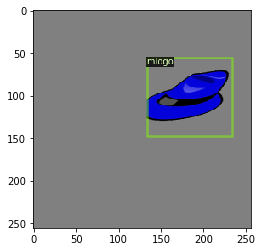

In [8]:
sample_plot(rhlogo_train, rhlogo_train_metadata, './')

In [9]:
trainer, cfg = prepare_for_training(1000, 
                                    'rhlogo_output', 
                                    'rhlogo_train', 
                                    1, 
                                    start_training=True)

[03/10 20:09:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[03/10 20:09:45 d2.data.build]: Removed 0 images with no usable annotations. 128 images left.
[03/10 20:09:45 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   rhlogo   | 128          |
|            |              |
[03/10 20:09:45 d2.data.common]: Serializing 128 elements to byte tensors and concatenating them all ...
[03/10 20:09:45 d2.data.common]: Serialized dataset takes 0.03 MiB
[03/10 20:09:45 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/10 20:09:45 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[03/10 20:09:46 d2.engine.train_loop]: Starting training from iteration 0
[03/10 20:09:52 d2.utils.events]:  eta: 0:04:20  iter: 19  total_loss: 1.427  loss_cls: 0.791  loss_box_reg: 0.601  loss_rpn_cls: 0.028  loss_rpn_loc: 0.012  time: 0.2693  data_time: 0.0078  lr: 0.000005  max_mem: 1763M
[03/10 20:09:57 d2.utils.events]:  eta: 0:04:15  iter: 39  total_loss: 1.253  loss_cls: 0.660  loss_box_reg: 0.554  loss_rpn_cls: 0.024  loss_rpn_loc: 0.012  time: 0.2686  data_time: 0.0033  lr: 0.000010  max_mem: 1763M
[03/10 20:10:03 d2.utils.events]:  eta: 0:04:10  iter: 59  total_loss: 1.199  loss_cls: 0.457  loss_box_reg: 0.668  loss_rpn_cls: 0.022  loss_rpn_loc: 0.014  time: 0.2690  data_time: 0.0035  lr: 0.000015  max_mem: 1763M
[03/10 20:10:08 d2.utils.events]:  eta: 0:04:05  iter: 79  total_loss: 0.936  loss_cls: 0.314  loss_box_reg: 0.565  loss_rpn_cls: 0.026  loss_rpn_loc: 0.012  time: 0.2690  data_time: 0.0031  lr: 0.000020  max_mem: 1763M
[03/10 20:10:13 d2.utils.events]:  eta: 0:04:0

[03/10 20:13:08 d2.utils.events]:  eta: 0:01:10  iter: 739  total_loss: 0.199  loss_cls: 0.031  loss_box_reg: 0.162  loss_rpn_cls: 0.001  loss_rpn_loc: 0.007  time: 0.2713  data_time: 0.0031  lr: 0.000185  max_mem: 1763M
[03/10 20:13:13 d2.utils.events]:  eta: 0:01:05  iter: 759  total_loss: 0.253  loss_cls: 0.026  loss_box_reg: 0.205  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  time: 0.2713  data_time: 0.0030  lr: 0.000190  max_mem: 1763M
[03/10 20:13:18 d2.utils.events]:  eta: 0:00:59  iter: 779  total_loss: 0.193  loss_cls: 0.026  loss_box_reg: 0.155  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  time: 0.2712  data_time: 0.0029  lr: 0.000195  max_mem: 1763M
[03/10 20:13:24 d2.utils.events]:  eta: 0:00:54  iter: 799  total_loss: 0.220  loss_cls: 0.030  loss_box_reg: 0.178  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  time: 0.2713  data_time: 0.0030  lr: 0.000200  max_mem: 1763M
[03/10 20:13:29 d2.utils.events]:  eta: 0:00:48  iter: 819  total_loss: 0.199  loss_cls: 0.026  loss_box_reg: 0.151 

In [14]:
cfg.MODEL.DEVICE = "cpu"
predictor = prepare_for_inference(cfg, 'rhlogo_test', threshold=0.70)

Reading weights from output dir: rhlogo_output


{'instances': Instances(num_instances=2, image_height=194, image_width=259, fields=[pred_boxes: Boxes(tensor([[ 45.2553,  81.6387,  60.4828,  96.5351],
         [220.4351, 115.5946, 258.1064, 194.0000]])), scores: tensor([0.8866, 0.7705]), pred_classes: tensor([0, 0])])}

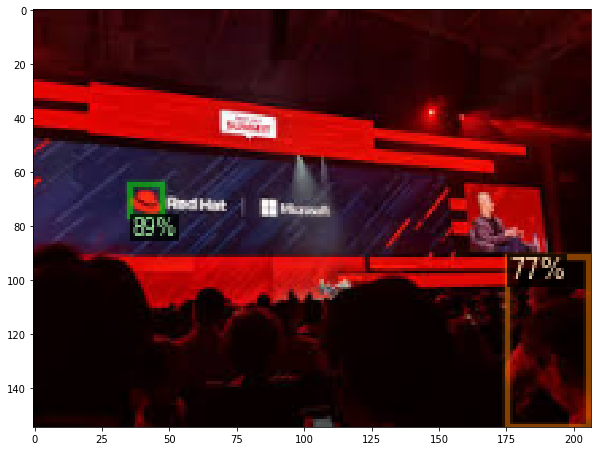

In [16]:
fig = plt.figure(figsize=(10,10))
infer_img(predictor, 'RHBKG2.jpg', rhlogo_train_metadata)

In [19]:
train_evaluator = COCOEvaluator('rhlogo_train', cfg, False, output_dir="rhlogo_output")

WARNING [03/10 20:19:48 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'rhlogo_train'. Trying to convert it to COCO format ...
[03/10 20:19:48 d2.data.datasets.coco]: Converting dataset annotations in 'rhlogo_train' to COCO format ...)
[03/10 20:19:48 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/10 20:19:48 d2.data.datasets.coco]: Conversion finished, num images: 128, num annotations: 128
[03/10 20:19:48 d2.data.datasets.coco]: Caching annotations in COCO format: rhlogo_output/rhlogo_train_coco_format.json


In [20]:
train_loader = build_detection_test_loader(cfg, "rhlogo_train")

[03/10 20:19:57 d2.data.common]: Serializing 128 elements to byte tensors and concatenating them all ...
[03/10 20:19:57 d2.data.common]: Serialized dataset takes 0.03 MiB


In [21]:
train_metrics = inference_on_dataset(trainer.model, train_loader, train_evaluator)

[03/10 20:20:08 d2.evaluation.evaluator]: Start inference on 128 images
[03/10 20:20:10 d2.evaluation.evaluator]: Inference done 11/128. 0.1630 s / img. ETA=0:00:19
[03/10 20:20:15 d2.evaluation.evaluator]: Inference done 44/128. 0.1525 s / img. ETA=0:00:12
[03/10 20:20:20 d2.evaluation.evaluator]: Inference done 79/128. 0.1476 s / img. ETA=0:00:07
[03/10 20:20:25 d2.evaluation.evaluator]: Inference done 113/128. 0.1471 s / img. ETA=0:00:02
[03/10 20:20:28 d2.evaluation.evaluator]: Total inference time: 0:00:18.427317 (0.149816 s / img per device, on 1 devices)
[03/10 20:20:28 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:18 (0.147718 s / img per device, on 1 devices)
[03/10 20:20:28 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/10 20:20:28 d2.evaluation.coco_evaluation]: Saving results to rhlogo_output/coco_instances_results.json
[03/10 20:20:28 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
D

OrderedDict([('bbox',
              {'AP': 85.17608791561304,
               'AP50': 100.0,
               'AP75': 95.01082920792079,
               'APs': nan,
               'APm': nan,
               'APl': 85.17608791561304})])

In [22]:
test_evaluator = COCOEvaluator('rhlogo_test', cfg, False, output_dir="rhlogo_output")

WARNING [03/10 20:21:28 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'rhlogo_test'. Trying to convert it to COCO format ...
[03/10 20:21:28 d2.data.datasets.coco]: Converting dataset annotations in 'rhlogo_test' to COCO format ...)
[03/10 20:21:28 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/10 20:21:28 d2.data.datasets.coco]: Conversion finished, num images: 128, num annotations: 128
[03/10 20:21:28 d2.data.datasets.coco]: Caching annotations in COCO format: rhlogo_output/rhlogo_test_coco_format.json


In [23]:
test_loader = build_detection_test_loader(cfg, "rhlogo_test")

[03/10 20:21:40 d2.data.common]: Serializing 128 elements to byte tensors and concatenating them all ...
[03/10 20:21:40 d2.data.common]: Serialized dataset takes 0.03 MiB


In [24]:
test_metrics = inference_on_dataset(trainer.model, test_loader, test_evaluator)

[03/10 20:22:01 d2.evaluation.evaluator]: Start inference on 128 images
[03/10 20:22:03 d2.evaluation.evaluator]: Inference done 11/128. 0.1556 s / img. ETA=0:00:18
[03/10 20:22:08 d2.evaluation.evaluator]: Inference done 46/128. 0.1439 s / img. ETA=0:00:11
[03/10 20:22:13 d2.evaluation.evaluator]: Inference done 80/128. 0.1462 s / img. ETA=0:00:07
[03/10 20:22:18 d2.evaluation.evaluator]: Inference done 117/128. 0.1433 s / img. ETA=0:00:01
[03/10 20:22:20 d2.evaluation.evaluator]: Total inference time: 0:00:17.947592 (0.145915 s / img per device, on 1 devices)
[03/10 20:22:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.143722 s / img per device, on 1 devices)
[03/10 20:22:20 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/10 20:22:20 d2.evaluation.coco_evaluation]: Saving results to rhlogo_output/coco_instances_results.json
[03/10 20:22:20 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
D

### Things to do:

1. add mAP (and others) as a metric (IN PROGRESS)

5. test onnx export 

2. look for models with lower latency

3. more diverse backgrounds (NICE BUT NOT URGENT)

6. clean and document code (NICE BUT NOT URGENT)

7. (maybe) multiple logos on same background (NICE BUT NOT URGENT)

4. add all 3 logos (DONE)

### Train on 4 logos

#### Generate new dataset - remove translations from transformations list

In [ ]:
N_images = 128
low_frac = 0.20
high_frac = 0.40

logo_file_list = ['RHLOGO.jpg',
                  'ANACONDALOGO.jpg',
                  'CLOUDERALOGO.jpg',
                  'SASLOGO.png']
name_list = [name.split('.')[0].replace('LOGO', '').lower() for name in logo_file_list]

In [ ]:
for idx in range(len(logo_file_list)):
    logo_file = logo_file_list[idx]
    name = name_list[idx]
    
    print(f"Generating logos for {name}")
    
    for dataset in ['train', 'test']:
        img_list, bbox_list, csv_fields = generate_augmented_dataset(N_images, 
                                                                     low_frac=low_frac,
                                                                     high_frac=high_frac,
                                                                     logo_file=logo_file,
                                                                     save_loc=f'logo_detector/{name}/{dataset}',
                                                                     logo_name=name)

#### Combine all four logos into same folder and labels csv file

In [ ]:
def check_combined_dataset(loc):
    
    label_file = os.path.join(loc, 'labels.csv')
    
    if not os.path.exists(label_file):
        raise ValueError("labels.csv doesn't exist. Please ensure loc argument is correct.")

    df_labels = pd.read_csv(label_file)
    csv_filenames = set(df_labels['filename'])
    
    filesystem_files = set(glob.glob(f"{loc}/*.png"))
    
    #ensures exactly same image files in filesystem tree and in csv files
    assert(len(csv_filenames.symmetric_difference(filesystem_files))==0)
    
    #ensure labels are correct between class column and image filenames
    N_correct = (df_labels['filename'].apply(lambda x: x.split('/')[-1].split('_')[0])==df_labels['class']).sum()
    
    assert(N_correct==df_labels.shape[0])
    
def combine_datasets(loc):
    '''Hacky - replace os by pathlib
    Add checks
    '''
    
    target_path = os.path.join(loc, 'combined')
    if os.path.exists(target_path):
        shutil.rmtree(target_path, ignore_errors=True)
    
    logo_list = os.listdir(loc) #rh,anaconda...
    dataset_type_list = os.listdir(os.path.join(loc, logo_list[0]))#train,test
    
    for dataset in dataset_type_list:#create combined/train, combined/test
        pathlib.Path(os.path.join(loc, 'combined', dataset)).mkdir(parents=True, exist_ok=True)
    
    #copy images over
    df_dict = {}
    for logo in logo_list: #rh
        for dataset in dataset_type_list: #train
            #csv files
            if dataset not in df_dict:
                df_dict[dataset] = []
            df_dict[dataset].append(pd.read_csv(os.path.join(loc, logo, dataset, f'{logo}.csv')))
            
            for img_file in glob.glob(os.path.join(loc, logo, dataset, '*.png')):
                shutil.copy2(img_file, os.path.join(loc, 'combined', dataset))
    
    def create_path(path, idx_to_exclude):
        return '/'.join([val if idx!=idx_to_exclude else "combined" for idx, val in enumerate(path.split('/'))]) 
    
    #process csvs
    for dataset in df_dict:
        df = pd.concat(df_dict[dataset], axis=0)
        
        df['filename'] = df['filename'].apply(lambda x: create_path(x, 1))
        
        df.to_csv(os.path.join(loc, 'combined', dataset, 'labels.csv'), index=False)
        
        check_combined_dataset(os.path.join(loc, 'combined', dataset))

In [ ]:
combine_datasets('logo_detector')

#### Convert CSV files to JSONs

In [ ]:
#convert csv to json - move to notebook
!python convert_csv_to_detectron.py logo_detector/combined/train/labels.csv logo_detector/combined/train/data.json
!python convert_csv_to_detectron.py logo_detector/combined/test/labels.csv logo_detector/combined/test/data.json

#### Train Model

In [27]:
#clear any catalogs
DatasetCatalog.clear()
MetadataCatalog._NAME_TO_META = {}

In [28]:
#json with labels
logo_train = get_dicts('logo_detector/combined/train')
print(logo_train[0])

{'image_id': 0, 'file_name': 'logo_detector/combined/train/anaconda_aacmpy.png', 'height': 512, 'width': 512, 'annotations': [{'bbox': [161, 246, 265, 378], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2}]}


In [29]:
#get labels
labels = list(pd.read_csv('logo_detector/combined/train/labels.csv')['class'].unique())
print(labels)

['sas', 'rh', 'anaconda', 'cloudera']


In [30]:
#register datasets
register('logo_detector/combined', labels, ['train', 'test'])

In [31]:
logo_train_metadata = get_metadata('logo_detector/combined_train')

{'image_id': 34, 'file_name': 'logo_detector/combined/train/anaconda_ghuwah.png', 'height': 512, 'width': 512, 'annotations': [{'bbox': [47, 167, 225, 294], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2}]}


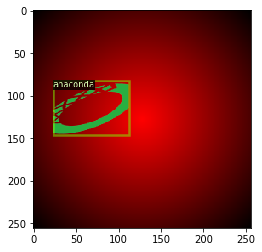

In [32]:
#plot data
sample_plot(logo_train, logo_train_metadata, '.')

In [33]:
N_classes = 4
trainer, cfg = prepare_for_training(2000, 
                                    'logo_detector_output', 
                                    'logo_detector/combined_train', 
                                    N_classes, 
                                    start_training=True)

[03/10 20:50:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[03/10 20:50:04 d2.data.build]: Removed 0 images with no usable annotations. 512 images left.
[03/10 20:50:04 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    sas     | 128          |     rh     | 128          |  anaconda  | 128          |
|  cloudera  | 128          |            |              |            |              |
|   total    | 512          |            |              |            |              |
[03/10 20:50:04 d2.data.common]: Serializing 512 elements to byte tensors and concatenating them all ...
[03/10 20:50:04 d2.data.common]: Serialized dataset takes 0.11 MiB
[03/10 20:50:04 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/10 20:50:04 d2.data.b

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (5, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (16, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.


[03/10 20:50:04 d2.engine.train_loop]: Starting training from iteration 0
[03/10 20:50:10 d2.utils.events]:  eta: 0:09:12  iter: 19  total_loss: 2.410  loss_cls: 1.624  loss_box_reg: 0.529  loss_rpn_cls: 0.135  loss_rpn_loc: 0.020  time: 0.2795  data_time: 0.0156  lr: 0.000005  max_mem: 2412M
[03/10 20:50:15 d2.utils.events]:  eta: 0:08:53  iter: 39  total_loss: 2.052  loss_cls: 1.410  loss_box_reg: 0.550  loss_rpn_cls: 0.114  loss_rpn_loc: 0.022  time: 0.2730  data_time: 0.0032  lr: 0.000010  max_mem: 2412M
[03/10 20:50:20 d2.utils.events]:  eta: 0:08:43  iter: 59  total_loss: 1.660  loss_cls: 1.044  loss_box_reg: 0.548  loss_rpn_cls: 0.074  loss_rpn_loc: 0.015  time: 0.2701  data_time: 0.0031  lr: 0.000015  max_mem: 2412M
[03/10 20:50:26 d2.utils.events]:  eta: 0:08:38  iter: 79  total_loss: 1.422  loss_cls: 0.689  loss_box_reg: 0.550  loss_rpn_cls: 0.083  loss_rpn_loc: 0.015  time: 0.2692  data_time: 0.0031  lr: 0.000020  max_mem: 2412M
[03/10 20:50:31 d2.utils.events]:  eta: 0:08:3

[03/10 20:53:25 d2.utils.events]:  eta: 0:05:41  iter: 739  total_loss: 0.425  loss_cls: 0.049  loss_box_reg: 0.339  loss_rpn_cls: 0.003  loss_rpn_loc: 0.012  time: 0.2705  data_time: 0.0031  lr: 0.000185  max_mem: 2412M
[03/10 20:53:30 d2.utils.events]:  eta: 0:05:35  iter: 759  total_loss: 0.416  loss_cls: 0.058  loss_box_reg: 0.347  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.2705  data_time: 0.0031  lr: 0.000190  max_mem: 2412M
[03/10 20:53:36 d2.utils.events]:  eta: 0:05:30  iter: 779  total_loss: 0.359  loss_cls: 0.049  loss_box_reg: 0.286  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.2705  data_time: 0.0030  lr: 0.000195  max_mem: 2412M
[03/10 20:53:41 d2.utils.events]:  eta: 0:05:25  iter: 799  total_loss: 0.385  loss_cls: 0.064  loss_box_reg: 0.302  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.2706  data_time: 0.0034  lr: 0.000200  max_mem: 2412M
[03/10 20:53:47 d2.utils.events]:  eta: 0:05:19  iter: 819  total_loss: 0.357  loss_cls: 0.052  loss_box_reg: 0.286 

[03/10 20:56:41 d2.utils.events]:  eta: 0:02:27  iter: 1459  total_loss: 0.240  loss_cls: 0.038  loss_box_reg: 0.195  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.2711  data_time: 0.0030  lr: 0.000250  max_mem: 2412M
[03/10 20:56:46 d2.utils.events]:  eta: 0:02:21  iter: 1479  total_loss: 0.262  loss_cls: 0.041  loss_box_reg: 0.213  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.2711  data_time: 0.0029  lr: 0.000250  max_mem: 2412M
[03/10 20:56:52 d2.utils.events]:  eta: 0:02:16  iter: 1499  total_loss: 0.253  loss_cls: 0.040  loss_box_reg: 0.211  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.2712  data_time: 0.0030  lr: 0.000250  max_mem: 2412M
[03/10 20:56:57 d2.utils.events]:  eta: 0:02:10  iter: 1519  total_loss: 0.245  loss_cls: 0.038  loss_box_reg: 0.197  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  time: 0.2712  data_time: 0.0030  lr: 0.000250  max_mem: 2412M
[03/10 20:57:03 d2.utils.events]:  eta: 0:02:05  iter: 1539  total_loss: 0.265  loss_cls: 0.039  loss_box_reg: 0

In [34]:
#trainer_discard, cfg = prepare_for_training(2000, 
#                                            'logo_detector_output', 
#                                            'logo_detector/combined_train', 
#                                            4, 
#                                            start_training=False)
predictor = prepare_for_inference(cfg, 'logo_detector/combined_test', threshold=0.50)

Reading weights from output dir: logo_detector_output


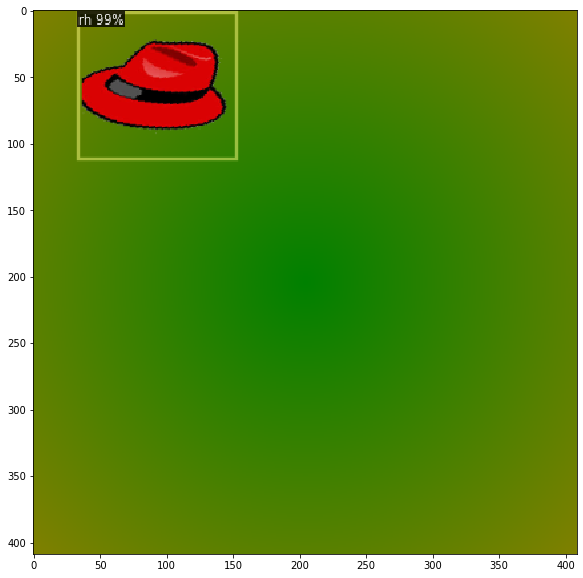

In [35]:
plt.figure(figsize=(10,10))
_ = infer_img(predictor, 'logo_detector/combined/test/rh_jnptos.png', logo_train_metadata)

#### Model Metrics

##### How do we measure the performance of an object detection model?

###### Binary classification
At the highest level, object detection is a classification task and all the usual metrics - true positives (TP), false positives (FP), true negatives (TN), false negatives (FN), area under the curve (AUC), precision, recall etc. apply.

For completeness, we'll quicky recap these for binary classification. We are given two classes, denoted by 0 and 1. Our predictions are **scores** between 0 and 1. We can pick a threshold $\delta$ such that any predicted score, $s > \delta$ is treated as a prediction of class 1 and any predicted score $s \leq \delta$ is treated as a prediction of class 0.

Once we have these predictions, we can compute a confusion matrix consisting of four quantities:

True positives: # examples with label = 1 and predicted = 1

False positives: # examples with label = 0 and predicted = 1

True negatives: # examples with label = 0 and predicted = 0

False negatives: # examples with label = 1 and predicted = 0

These names are a bit obnoxious but an easy way to remember the names is: the "true"/"false" part refers to whether the prediction was correct or incorrect. The "positive"/"negative" part refers to the predictions 1/0. So false positives refers to the number of examples that were predicted incorrectly and were predicted to be positive (1). In other words, their actual labels were 0 but they were predicted to be 1.

At this stage, we can define operationally meaningful quantities like:

**Precision**: $\frac{\text{TP}}{\text{TP} + \text{FP}}$

The denominator is the number of all examples that are *predicted* to be positive and the numerator is the number of positive predictions that were correct. If a model is running in production, this quantity defines on useful it would be. For example, if our task was whether a credit card transaction is fraudulent or not, precision would tell us what percentage of the transactions flagged by our model are actually fraudulent. Informally, a high precision would make our job as the human operators easy because we can "trust" the model's flagged transactions to be actually fraudulent.

**Recall**: $\frac{\text{TP}}{\text{TP} + \text{FN}}$

The denominator here is the number of all examples that were *labeled* positive. This is because FN is the number of examples that were predicted incorrectly to be negative (0). That means their labels were positive (1).

Recall tells us what percentage of the actual positive examples in the dataset that were predicted correctly to be positive. In our credit card example, this is the percentage of training/validation transactions that were labelled as fraudulent and were predicted correctly. 

Generally, there is a tradeoff between precision and recall. High recall means the model predicts more of the actual positives to be positive but at the cost of leaking in some false positives which brings the precision lower.

**Precision-Recall Curve**: Since both precision and recall depend on the threshold, $\delta$, we usually vary $\delta$ from 0 to 1 and measure the precision and recall at each threshold. This gives us a parameterized curve in the precision-recall space. We can measure the area under this curve to get one metric that expresses how good the model is. 

INSERT PICTURE

Generally a smoothing/interpolation operation is done before computing the area. The idea is to compute an "interpolated" precision for each recall value in our plot. The intuition is very simple: For a fixed recall $r_i$, we have a fixed precision $p_i$ where i = $1,2,\ldots,n$ denotes the n threshold, $\delta_i$ we chose (in increasing order). In practice, if we had a recall $r_j$ that was higher than $r_i$ with a corresponding precision $p_j$ that was also higher than $p_i$, then naturally we would choose the point with both the higher precision and higher recall. Generally this doesn't happen because of the precision-recall tradeoff but the tradeoff isn't strict and in practice, it does get violated for individual points.

In this case, we take our original point $r_i$ and assign it an interpolated precision:

$$p_{\text{interp},i} = \max_{j \geq i} p_j$$

All we are saying here is that if we find any point with a higher recall and a higher precision, then we can safely presume that we can get the same recall $r_i$ with the higher precision. Geometrically, this has the effect of removing the spikiness of the precision-recall curve. Now, we can numerically compute the area under the curve.

$AP = \Sigma_{i} p_{\text{interp},i+1}(r_{i+1}-r_{i})$

where AP stands for average precision.

For classification tasks with K classes, one can define the **mean Averaged Precision (mAP)** as

$mAP = \frac{1}{K} \Sigma_{i=1}^K AP(i)$

where we just average the average precisions compute for each of the K binary classification problems (1 vs all).

###### Object Detection

Let's move on to object detection now. Across all our images, we have labeled bounding boxes (rectangles), and the predictions are bounding boxes with an additional classification score, s between 0 and 1, just like the classification problem above.

Question: how do we decide if a predicted bounding box is correct or incorrect?

In this case, we need two thresholds. The first threshold, $\delta$ tells us whether a classification score is high enough or not. If $s \geq \delta$, we consider the predicted box and if $s \leq \delta$, we discard the box as a noisy artifact.

Now we have a list of labeled boxes as well as high confidence predicted boxes. But they won't overlap perfectly. The natural approach is to look at the overlap in area between a labeled box and a predicted box. If this overlap is greater than some threshold, $\tau$, then we can potentially consider the prediction to be correct and if the overlap is less than the threshold, then that particular predicted box is incorrect for the labeled box.

The overlap is measured by looking at intersection-over-union (IoU), which can be used to compute the overlap between any two sets, A and B as:

$IoU(A,B) = \frac{|A \cap B|}{|A \cup B|}$

where $|A|$ denotes the cardinality or size of the set.

Till now, we have the following two steps:

1. Discard all predicted bounding boxes with classification score, $s \leq \delta$. We treat this boxes as false negatives.

2. For a given predicted box and label box, compute IoU(pred,label). If $IoU \geq \tau$, then we consider the prediction to be correct for this box.

What can go wrong here? What if there are two predicted boxes that are shifted just slightly from each other and overlap with a label box. In this case, we would get two true positive counts when we are just duplicating the same prediction. To 

In [36]:
DatasetCatalog.clear()
MetadataCatalog._NAME_TO_META = {}

In [37]:
#register datasets

#get labels
labels = list(pd.read_csv('logo_detector/combined/train/labels.csv')['class'].unique())
print(labels)    

register('logo_detector/combined', labels, ['train', 'test'])

['sas', 'rh', 'anaconda', 'cloudera']


In [ ]:
trainer, cfg = prepare_for_training(2000, 
                                    'logo_detector_output', 
                                    'logo_detector/combined_train', 
                                    4, 
                                    start_training=False)
predictor = prepare_for_inference(cfg, 'logo_detector/combined_test', threshold=0.50)

In [38]:
MetadataCatalog.list()

['logo_detector/combined_train', 'logo_detector/combined_test']

In [39]:
train_evaluator = COCOEvaluator('logo_detector/combined_train', cfg, False, output_dir="logo_detector_output")

WARNING [03/10 21:22:32 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'logo_detector/combined_train'. Trying to convert it to COCO format ...
[03/10 21:22:32 d2.data.datasets.coco]: Cached annotations in COCO format already exist: logo_detector_output/logo_detector/combined_train_coco_format.json


In [40]:
MetadataCatalog.get('logo_detector/combined_train')

Metadata(json_file='logo_detector_output/logo_detector/combined_train_coco_format.json', name='logo_detector/combined_train', thing_classes=['sas', 'rh', 'anaconda', 'cloudera'])

In [43]:
train_loader = build_detection_test_loader(cfg, "logo_detector/combined_train")

[03/10 21:23:23 d2.data.common]: Serializing 512 elements to byte tensors and concatenating them all ...
[03/10 21:23:23 d2.data.common]: Serialized dataset takes 0.11 MiB


In [44]:
train_metrics = inference_on_dataset(trainer.model, train_loader, train_evaluator)

[03/10 21:23:26 d2.evaluation.evaluator]: Start inference on 512 images
[03/10 21:23:28 d2.evaluation.evaluator]: Inference done 11/512. 0.1493 s / img. ETA=0:01:15
[03/10 21:23:33 d2.evaluation.evaluator]: Inference done 44/512. 0.1543 s / img. ETA=0:01:12
[03/10 21:23:38 d2.evaluation.evaluator]: Inference done 77/512. 0.1537 s / img. ETA=0:01:07
[03/10 21:23:43 d2.evaluation.evaluator]: Inference done 110/512. 0.1534 s / img. ETA=0:01:02
[03/10 21:23:48 d2.evaluation.evaluator]: Inference done 142/512. 0.1540 s / img. ETA=0:00:57
[03/10 21:23:53 d2.evaluation.evaluator]: Inference done 176/512. 0.1529 s / img. ETA=0:00:51
[03/10 21:23:58 d2.evaluation.evaluator]: Inference done 209/512. 0.1525 s / img. ETA=0:00:46
[03/10 21:24:03 d2.evaluation.evaluator]: Inference done 244/512. 0.1513 s / img. ETA=0:00:40
[03/10 21:24:08 d2.evaluation.evaluator]: Inference done 279/512. 0.1505 s / img. ETA=0:00:35
[03/10 21:24:13 d2.evaluation.evaluator]: Inference done 314/512. 0.1496 s / img. ETA

OrderedDict([('bbox',
              {'AP': 79.64409151336775,
               'AP50': 100.0,
               'AP75': 92.85185255531513,
               'APs': nan,
               'APm': nan,
               'APl': 79.64409151336775,
               'AP-sas': 82.5824281290984,
               'AP-rh': 79.00924387840708,
               'AP-anaconda': 86.84715918153037,
               'AP-cloudera': 70.13753486443517})])

In [45]:
test_evaluator = COCOEvaluator('logo_detector/combined_test', cfg, False, output_dir="logo_detector_output")

WARNING [03/10 21:25:35 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'logo_detector/combined_test'. Trying to convert it to COCO format ...
[03/10 21:25:35 d2.data.datasets.coco]: Converting dataset annotations in 'logo_detector/combined_test' to COCO format ...)
[03/10 21:25:35 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/10 21:25:35 d2.data.datasets.coco]: Conversion finished, num images: 512, num annotations: 512
[03/10 21:25:35 d2.data.datasets.coco]: Caching annotations in COCO format: logo_detector_output/logo_detector/combined_test_coco_format.json


In [46]:
test_loader = build_detection_test_loader(cfg, "logo_detector/combined_test")

[03/10 21:25:49 d2.data.common]: Serializing 512 elements to byte tensors and concatenating them all ...
[03/10 21:25:49 d2.data.common]: Serialized dataset takes 0.11 MiB


In [47]:
test_metrics = inference_on_dataset(trainer.model, test_loader, test_evaluator)

[03/10 21:26:09 d2.evaluation.evaluator]: Start inference on 512 images
[03/10 21:26:11 d2.evaluation.evaluator]: Inference done 11/512. 0.1584 s / img. ETA=0:01:19
[03/10 21:26:16 d2.evaluation.evaluator]: Inference done 44/512. 0.1538 s / img. ETA=0:01:12
[03/10 21:26:21 d2.evaluation.evaluator]: Inference done 76/512. 0.1543 s / img. ETA=0:01:07
[03/10 21:26:26 d2.evaluation.evaluator]: Inference done 110/512. 0.1523 s / img. ETA=0:01:01
[03/10 21:26:31 d2.evaluation.evaluator]: Inference done 143/512. 0.1525 s / img. ETA=0:00:56
[03/10 21:26:36 d2.evaluation.evaluator]: Inference done 177/512. 0.1515 s / img. ETA=0:00:51
[03/10 21:26:41 d2.evaluation.evaluator]: Inference done 210/512. 0.1514 s / img. ETA=0:00:46
[03/10 21:26:46 d2.evaluation.evaluator]: Inference done 244/512. 0.1509 s / img. ETA=0:00:40
[03/10 21:26:51 d2.evaluation.evaluator]: Inference done 279/512. 0.1501 s / img. ETA=0:00:35
[03/10 21:26:56 d2.evaluation.evaluator]: Inference done 314/512. 0.1494 s / img. ETA

#### Model Persistence and Loading

Note: do we really need ONNX?